# Proyecto de Consultoría a Hyundai Heavy
## Laboratorio 10

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, count, when, isnan, corr, max as spark_max, min as spark_min, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Iniciar sesión de Spark

In [9]:
spark = SparkSession.builder.appName("Lab Spark RL — Hyundai Heavy").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


### Carga del archivo CSV

In [26]:
df_hyundai = spark.read.csv(
    '/content/barcos_crucero.csv',
    header=True,
    inferSchema=True
)

## Análisis de los datos

In [27]:
# Contar registros
total_registros = df_hyundai.count()
print(f"Total de barcos en el dataset: {total_registros}")

Total de barcos en el dataset: 158


In [28]:
df_hyundai.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [29]:
df_hyundai.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [46]:
# Verificar valores nulos
print("\n Análisis de Valores Nulos:")
df_hyundai.select([count(when(col(c).isNull() | isnan(c), c)).alias(c)
                   for c in df_hyundai.columns]).show()


 Análisis de Valores Nulos:
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [37]:
# Verificar duplicados por nombre de barco
print("\n Verificación de Duplicados:")
duplicados = df_hyundai.groupBy("Ship_name").count().filter(col("count") > 1)
duplicate_count = duplicados.count()
print(f"Barcos con nombres duplicados: {duplicate_count}")
if duplicate_count > 0:
    duplicados.show()


 Verificación de Duplicados:
Barcos con nombres duplicados: 16
+---------+-----+
|Ship_name|count|
+---------+-----+
|     Wind|    2|
|  Majesty|    2|
|   Spirit|    4|
|     Dawn|    2|
|      Sun|    2|
|Navigator|    2|
|    Pride|    2|
|      Sea|    2|
| Rhapsody|    2|
|  Mariner|    2|
|  Freedom|    2|
|    Crown|    2|
|   Legend|    3|
|     Star|    3|
|    Jewel|    2|
|  Voyager|    2|
+---------+-----+



In [14]:
print("\nANÁLISIS DE LA VARIABLE OBJETIVO: CREW")
print("-" * 80)

crew_stats = df_hyundai.select("crew").describe()
crew_stats.show()

# Convertir a Pandas para visualización
crew_pandas = df_hyundai.select("crew").toPandas()
print(f"Rango de tripulación: {crew_pandas['crew'].min():.2f} - {crew_pandas['crew'].max():.2f} (en 100s)")
print(f"Mediana de tripulación: {crew_pandas['crew'].median():.2f} (en 100s)")


ANÁLISIS DE LA VARIABLE OBJETIVO: CREW
--------------------------------------------------------------------------------
+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+

Rango de tripulación: 0.59 - 21.00 (en 100s)
Mediana de tripulación: 8.15 (en 100s)


In [38]:
print("\n MATRIZ DE CORRELACIÓN")
print("-" * 80)

# Seleccionar solo variables numéricas (excluir Ship_name y Cruise_line)
numeric_cols = ["Age", "Tonnage", "passengers", "length", "cabins",
                "passenger_density", "crew"]

# Convertir a Pandas para análisis de correlación más fácil
df_pandas = df_hyundai.select(numeric_cols).toPandas()

# Matriz de correlación
correlation_matrix = df_pandas.corr()
print("\nMatriz de Correlación con CREW (Variable Objetivo):")
crew_correlations = correlation_matrix["crew"].sort_values(ascending=False)
print(crew_correlations)


 MATRIZ DE CORRELACIÓN
--------------------------------------------------------------------------------

Matriz de Correlación con CREW (Variable Objetivo):
crew                 1.000000
cabins               0.950823
Tonnage              0.927569
passengers           0.915234
length               0.895857
passenger_density   -0.155509
Age                 -0.530657
Name: crew, dtype: float64


✓ Guardado: correlation_heatmap.png


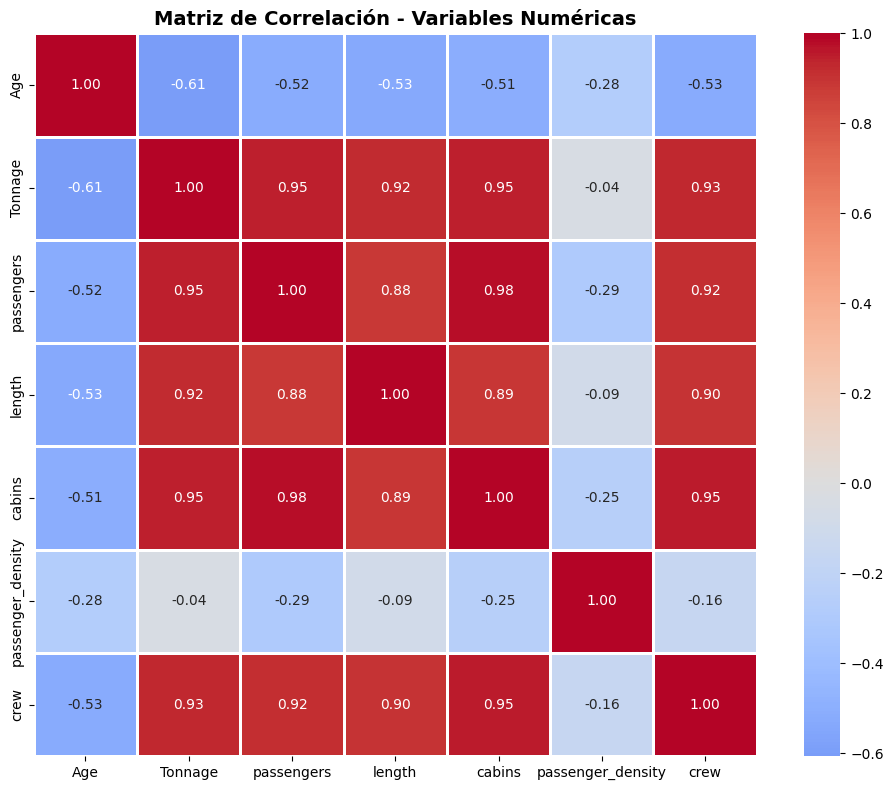

In [18]:
# Heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()

In [39]:
# Identificar multicolinealidad (correlaciones altas entre predictores)
print("\nAnálisis de Multicolinealidad:")
print("Pares de variables con correlación > 0.9:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            print(f"  - {correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: "
                  f"{correlation_matrix.iloc[i, j]:.3f}")


Análisis de Multicolinealidad:
Pares de variables con correlación > 0.9:
  - Tonnage vs passengers: 0.945
  - Tonnage vs length: 0.922
  - Tonnage vs cabins: 0.949
  - Tonnage vs crew: 0.928
  - passengers vs cabins: 0.976
  - passengers vs crew: 0.915
  - cabins vs crew: 0.951


## Gráficas útiles

✓ Guardado: crew_distribution.png


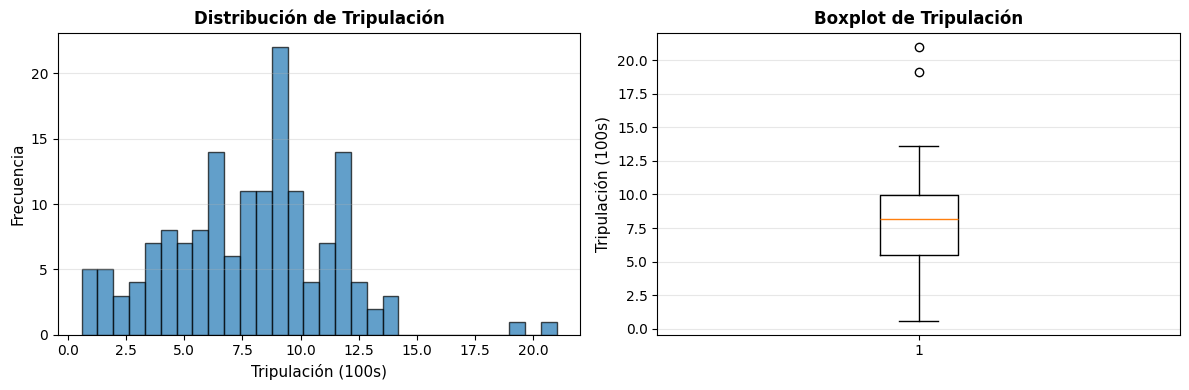

In [40]:
# Distribución de la variable objetivo
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(crew_pandas['crew'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Tripulación (100s)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.title('Distribución de Tripulación', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(crew_pandas['crew'], vert=True)
plt.ylabel('Tripulación (100s)', fontsize=11)
plt.title('Boxplot de Tripulación', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

✓ Guardado: top_correlations_scatter.png


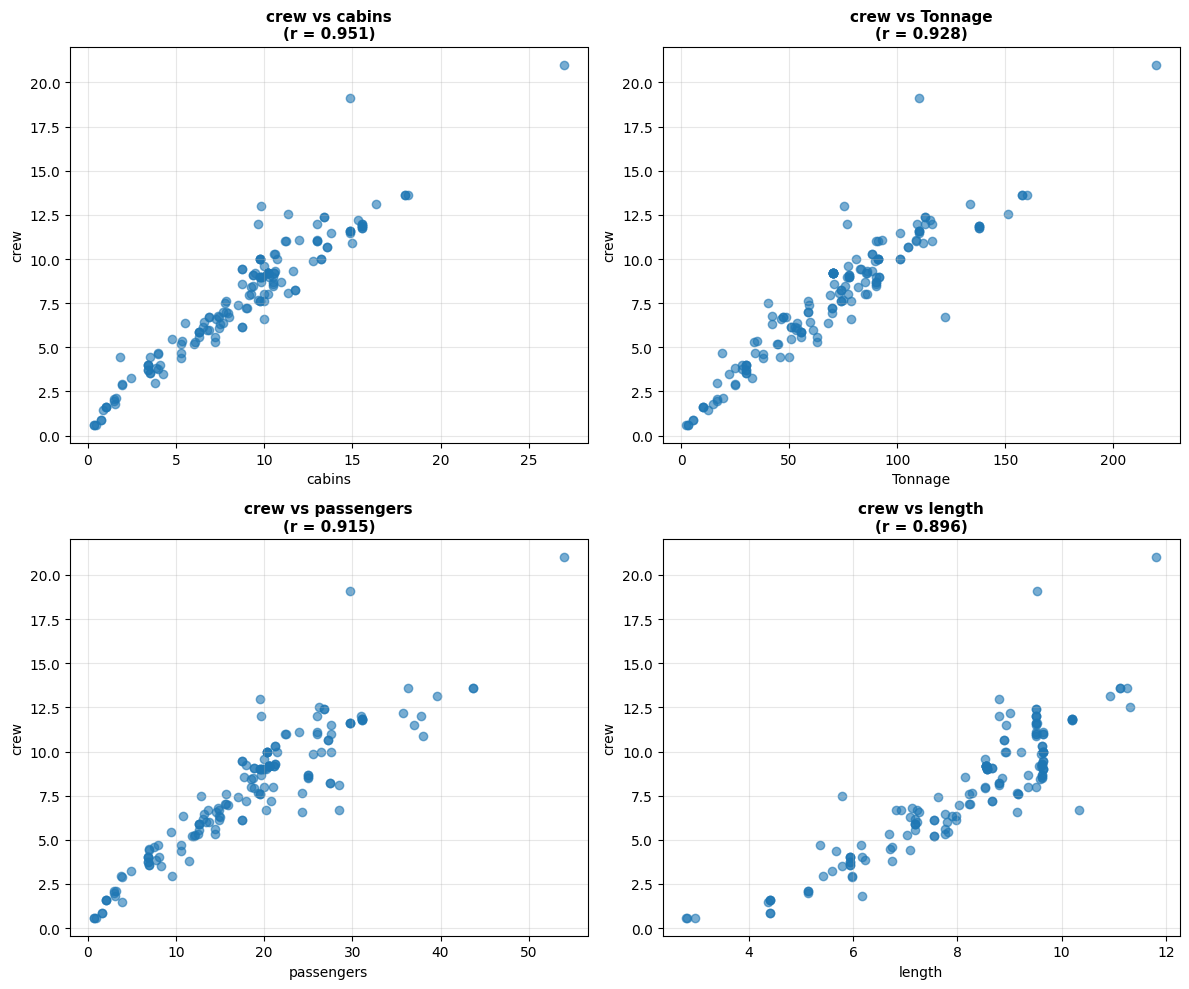

In [41]:
# Scatterplots de las variables más correlacionadas con crew
top_features = crew_correlations.drop('crew').head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, feature in enumerate(top_features):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(df_pandas[feature], df_pandas['crew'], alpha=0.6)
    axes[row, col].set_xlabel(feature, fontsize=10)
    axes[row, col].set_ylabel('crew', fontsize=10)
    axes[row, col].set_title(f'crew vs {feature}\n(r = {crew_correlations[feature]:.3f})',
                              fontsize=11, fontweight='bold')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()

In [50]:
print("\nANÁLISIS DE CRUISE_LINE")
print("-" * 80)

# Contar líneas de cruceros
cruise_counts = df_hyundai.groupBy("Cruise_line").count().orderBy(col("count").desc())
print("\nDistribución de Líneas de Cruceros:")
cruise_counts.show(20)

num_cruise_lines = cruise_counts.count()
print(f"\nTotal de líneas de cruceros diferentes: {num_cruise_lines}")


ANÁLISIS DE CRUISE_LINE
--------------------------------------------------------------------------------

Distribución de Líneas de Cruceros:
+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+


Total de líneas de cruceros diferentes: 20


In [53]:
print("\nEstadísticas de Tripulación por Línea de Cruceros:")
crew_by_cruise = df_hyundai.groupBy("Cruise_line").agg(
    count("crew").alias("num_barcos"),
    mean("crew").alias("promedio_crew"),
    spark_min("crew").alias("min_crew"),
    spark_max("crew").alias("max_crew")
).orderBy(col("promedio_crew").desc())
crew_by_cruise.show(10)


Estadísticas de Tripulación por Línea de Cruceros:
+---------------+----------+------------------+--------+--------+
|    Cruise_line|num_barcos|     promedio_crew|min_crew|max_crew|
+---------------+----------+------------------+--------+--------+
|         Cunard|         3|10.246666666666668|     9.0|   12.53|
|       Carnival|        22| 10.13590909090909|     6.6|    19.1|
|Royal_Caribbean|        23|10.016521739130434|     6.6|    21.0|
|         Disney|         2|              9.45|    9.45|    9.45|
|       Princess|        17|  9.32235294117647|    3.73|   12.38|
|            P&O|         6| 8.588333333333333|     5.2|    12.2|
|      Norwegian|        13| 8.087692307692308|     3.8|    13.0|
|      Celebrity|        10|             8.072|     0.6|    9.99|
|          Costa|        11|               7.7|    3.85|    10.9|
|            MSC|         8|              7.54|    2.97|   13.13|
+---------------+----------+------------------+--------+--------+
only showing top 10 rows

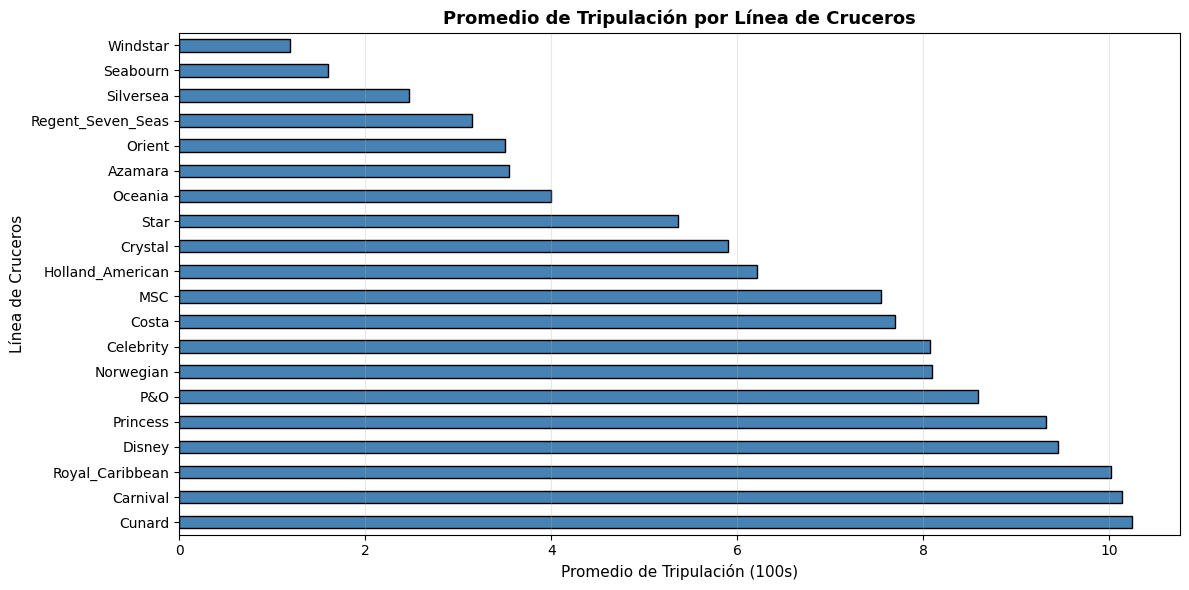

In [54]:
# Visualización
cruise_crew_pandas = df_hyundai.select("Cruise_line", "crew").toPandas()
cruise_crew_avg = cruise_crew_pandas.groupby("Cruise_line")["crew"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
cruise_crew_avg.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Promedio de Tripulación (100s)', fontsize=11)
plt.ylabel('Línea de Cruceros', fontsize=11)
plt.title('Promedio de Tripulación por Línea de Cruceros', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

In [55]:
print("\nCODIFICACIÓN DE CRUISE_LINE")
print("-" * 80)

# Opción 1: StringIndexer (convierte a índices numéricos)
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_index")
df_indexed = indexer.fit(df_hyundai).transform(df_hyundai)

print("\nStringIndexer aplicado:")
df_indexed.select("Cruise_line", "Cruise_line_index").distinct().orderBy("Cruise_line_index").show(10)


CODIFICACIÓN DE CRUISE_LINE
--------------------------------------------------------------------------------

StringIndexer aplicado:
+----------------+-----------------+
|     Cruise_line|Cruise_line_index|
+----------------+-----------------+
| Royal_Caribbean|              0.0|
|        Carnival|              1.0|
|        Princess|              2.0|
|Holland_American|              3.0|
|       Norwegian|              4.0|
|           Costa|              5.0|
|       Celebrity|              6.0|
|             MSC|              7.0|
|             P&O|              8.0|
|            Star|              9.0|
+----------------+-----------------+
only showing top 10 rows



In [56]:
# Opción 2: OneHotEncoder (crea variables dummy)
encoder = OneHotEncoder(inputCols=["Cruise_line_index"],
                        outputCols=["Cruise_line_encoded"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

print("\nOneHotEncoder aplicado (vector denso):")
print("✓ Variable 'Cruise_line_encoded' creada (vector sparse)")

# Mostrar resultado
df_encoded.select("Cruise_line", "Cruise_line_index", "Cruise_line_encoded").show(5, truncate=False)


OneHotEncoder aplicado (vector denso):
✓ Variable 'Cruise_line_encoded' creada (vector sparse)
+-----------+-----------------+-------------------+
|Cruise_line|Cruise_line_index|Cruise_line_encoded|
+-----------+-----------------+-------------------+
|Azamara    |16.0             |(19,[16],[1.0])    |
|Azamara    |16.0             |(19,[16],[1.0])    |
|Carnival   |1.0              |(19,[1],[1.0])     |
|Carnival   |1.0              |(19,[1],[1.0])     |
|Carnival   |1.0              |(19,[1],[1.0])     |
+-----------+-----------------+-------------------+
only showing top 5 rows



## Preparación final de los datos

In [47]:
# Versión 1: Con OneHotEncoding de Cruise_line
feature_cols_v1 = ["Age", "Tonnage", "passengers", "length", "cabins",
                   "passenger_density", "Cruise_line_encoded"]

assembler_v1 = VectorAssembler(inputCols=feature_cols_v1, outputCol="features")
df_final_v1 = assembler_v1.transform(df_encoded)

print("\nDataFrame VERSIÓN 1 (con todas las features + OneHotEncoding):")
df_final_v1.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 1 (con todas las features + OneHotEncoding):
+-----------------------------------------------------------------------+----+
|features                                                               |crew|
+-----------------------------------------------------------------------+----+
|(25,[0,1,2,3,4,5,22],[6.0,30.276999999999997,6.94,5.94,3.55,42.64,1.0])|3.55|
|(25,[0,1,2,3,4,5,22],[6.0,30.276999999999997,6.94,5.94,3.55,42.64,1.0])|3.55|
|(25,[0,1,2,3,4,5,7],[26.0,47.262,14.86,7.22,7.43,31.8,1.0])            |6.7 |
|(25,[0,1,2,3,4,5,7],[11.0,110.0,29.74,9.53,14.88,36.99,1.0])           |19.1|
|(25,[0,1,2,3,4,5,7],[17.0,101.353,26.42,8.92,13.21,38.36,1.0])         |10.0|
+-----------------------------------------------------------------------+----+
only showing top 5 rows



In [48]:
# Versión 2: Solo con features recomendadas
feature_cols_v2 = ["Tonnage", "cabins", "passenger_density", "Cruise_line_encoded"]

assembler_v2 = VectorAssembler(inputCols=feature_cols_v2, outputCol="features")
df_final_v2 = assembler_v2.transform(df_encoded)

print("\nDataFrame VERSIÓN 2 (features recomendadas + OneHotEncoding):")
df_final_v2.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 2 (features recomendadas + OneHotEncoding):
+---------------------------------------------------+----+
|features                                           |crew|
+---------------------------------------------------+----+
|(22,[0,1,2,19],[30.276999999999997,3.55,42.64,1.0])|3.55|
|(22,[0,1,2,19],[30.276999999999997,3.55,42.64,1.0])|3.55|
|(22,[0,1,2,4],[47.262,7.43,31.8,1.0])              |6.7 |
|(22,[0,1,2,4],[110.0,14.88,36.99,1.0])             |19.1|
|(22,[0,1,2,4],[101.353,13.21,38.36,1.0])           |10.0|
+---------------------------------------------------+----+
only showing top 5 rows



In [49]:
# Versión 3: Sin OneHotEncoding, solo con índice numérico
feature_cols_v3 = ["Tonnage", "cabins", "passenger_density", "Cruise_line_index"]

assembler_v3 = VectorAssembler(inputCols=feature_cols_v3, outputCol="features")
df_final_v3 = assembler_v3.transform(df_indexed)

print("\nDataFrame VERSIÓN 3 (features recomendadas + StringIndexer):")
df_final_v3.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 3 (features recomendadas + StringIndexer):
+------------------------------------+----+
|features                            |crew|
+------------------------------------+----+
|[30.276999999999997,3.55,42.64,16.0]|3.55|
|[30.276999999999997,3.55,42.64,16.0]|3.55|
|[47.262,7.43,31.8,1.0]              |6.7 |
|[110.0,14.88,36.99,1.0]             |19.1|
|[101.353,13.21,38.36,1.0]           |10.0|
+------------------------------------+----+
only showing top 5 rows

